In [1]:
# %%writefile pickle_nlp_boosting_model.py
from pymongo import MongoClient
import numpy as np
import pandas as pd
from my_tools import get_bill_data, process_corpus, read_jsonl_file
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score, confusion_matrix

from sklearn.externals import joblib


print('-------------------')
print('Loading original and preprocessed data for vectorizing and modeling...')
data, in_progress = get_bill_data()

# drop bill text column from data and retrieve preprocessed text from corpus_with_labels.jsonl
data.drop('body', axis = 1, inplace = True)

corpus_with_labels = read_jsonl_file('/home/ubuntu/galvanize_capstone/data/nlp/corpus_with_labels.jsonl')
corpus_df = pd.DataFrame(list(corpus_with_labels))

X = corpus_df['document']
y = corpus_df['label'].astype(int)


# create stratified train-test split
print('-------------------')
print('Performing train-test split...')
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)#, random_state = 123)

# vectorizing 6M of ~30M dimensions with n-grams, l1 norm (simple avg, l2 avg**2
# use_idf=True gives more weight to words, n_grams that appear less frequently in the corpus
# sublinear_tf=True reduces the bias of length
print('-------------------')
print('Vectorizing...')
tfvect = TfidfVectorizer(ngram_range=(1, 4), 
#                          max_features = 6000000,
                         norm = 'l2',              #default value
                         use_idf = True,           #default value
                         sublinear_tf = True)

X_train_vec = tfvect.fit_transform(X_train)
X_test_vec = tfvect.transform(X_test)

print('-------------------')
print('Getting Features...')
features = tfvect.get_feature_names()

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


-------------------
Loading original and preprocessed data for vectorizing and modeling...
------------------
------------------
Data includes bills, joints resolutions, and laws with text from the 110th Congress (2007) to present
Make changes in my_tools.get_bill_data to modify the data set.
------------------
-------------------
Performing train-test split...
-------------------
Vectorizing...
-------------------
Creating vocabulary...


In [7]:
# dump the TfidfVectorizer
print('-------------------')
print('Pickling the TfidfVectorizer...')
pickle_path = 'pickle_files/tfidfVectorizer.pkl'
if os.path.exists(pickle_path):
    os.remove(pickle_path)
joblib.dump(tfvect, pickle_path)
print('Pickling complete.')

-------------------
Pickling the TfidfVectorizer...
Pickling complete.


In [3]:
# # load the TfidfVectorizer
# print('-------------------')
# print('Loading the pickled TfidfVectorizer...')
# pickle_path = 'pickle_files/tfidfVectorizer.pkl'
# tfvect = joblib.load(pickle_path)
# print('Pickled vectorizer loaded.')

In [4]:
X_train_vec.shape

(47486, 6000000)

In [5]:
print('-------------------')
print('Training Gradient Boosting Classifier with vectorized results...')
gb = GradientBoostingClassifier(loss= 'deviance', 
                                max_features = 6000000, 
                                learning_rate = .1, 
                                n_estimators = 100, 
                                criterion = 'friedman_mse', 
                                min_samples_split = 2, 
                                min_samples_leaf = 15, 
                                max_depth = 3, 
                                max_leaf_nodes = None)

gb.fit(X_train_vec, y_train)

print('-------------------')
print('Getting predictions...')
gb_y_pred = gb.predict(X_test_vec)
gb_y_pred_proba = gb.predict_proba(X_test_vec)

print('-------------------')
print('F1 Score:\t\t{:.4f}'.format(f1_score(y_test, gb_y_pred)))
print('Recall Score:\t\t{:.4f}'.format(recall_score(y_test, gb_y_pred)))
print('Precision Score:\t{:.4f}'.format(precision_score(y_test, gb_y_pred)))
print('Accuracy Score:\t\t{:.4f}'.format(accuracy_score(y_test, gb_y_pred)))

-------------------
Training Gradient Boosting Classifier with vectorized results...
-------------------
Getting predictions...
-------------------
F1 Score:		0.9407
Recall Score:		0.8946
Precision Score:	0.9918
Accuracy Score:		0.9961


In [6]:
gb_y_pred_proba

array([[0.99790061, 0.00209939],
       [0.99790061, 0.00209939],
       [0.99790061, 0.00209939],
       ...,
       [0.99790061, 0.00209939],
       [0.99790061, 0.00209939],
       [0.99790061, 0.00209939]])

In [8]:
# dump the Gradient Boosting Model
print('-------------------')
print('Pickling the Gradient Boosting Model...')
pickle_path = 'pickle_files/nlp_gradientBoost.pkl'
if os.path.exists(pickle_path):
    os.remove(pickle_path)
joblib.dump(gb, pickle_path)
print('Pickling complete.')

-------------------
Pickling the Gradient Boosting Model...
Pickling complete.


In [67]:
confusion_matrix(y_test, gb_y_pred)

array([[15284,     4],
       [   57,   484]])

In [64]:
diffs = y_test - gb_y_pred

fp_index_list = []
fn_index_list = []

for i, j in enumerate(diffs):
    if j == 1:
        print('Index {} is a False Negative'.format(i))
        fn_index_list.append(i)
    if j == -1:
        print('Index {} is a False Positive'.format(i))
        fp_index_list.append(i)


Index 356 is a False Negative
Index 1134 is a False Negative
Index 1446 is a False Negative
Index 1456 is a False Negative
Index 1561 is a False Negative
Index 1655 is a False Negative
Index 1929 is a False Negative
Index 2416 is a False Negative
Index 2623 is a False Negative
Index 3035 is a False Negative
Index 3142 is a False Negative
Index 3231 is a False Negative
Index 3320 is a False Negative
Index 3688 is a False Negative
Index 4116 is a False Negative
Index 4269 is a False Negative
Index 4325 is a False Negative
Index 4556 is a False Negative
Index 4568 is a False Positive
Index 4669 is a False Negative
Index 5204 is a False Positive
Index 5638 is a False Negative
Index 5857 is a False Negative
Index 5998 is a False Negative
Index 6746 is a False Negative
Index 7157 is a False Negative
Index 7485 is a False Negative
Index 7701 is a False Negative
Index 8032 is a False Negative
Index 8163 is a False Positive
Index 8215 is a False Negative
Index 8299 is a False Negative
Index 858

In [65]:
fp_index_list

[4568, 5204, 8163, 15649]

In [ ]:
gb_y_pred_proba[:,0].max()

In [71]:
X_test.shape

(15829,)

In [73]:
X_train[15649]

"adjust immigration status certain venezuelan national united state enacted united state america congress assembled section short title act may cited venezuelan refugee assistance act '' sec adjustment status certain venezuelan national adjustment status. general. notwithstanding section c immigration nationality act u.s.c c status alien described subsection b adjusted secretary homeland security alien lawfully admitted permanent residence alien applies adjustment january b inadmissible paragraph e g c section immigration nationality act u.s.c c deportable paragraph e g section act u.s.c ordered incited assisted otherwise participated persecution person account race religion nationality membership particular social group political opinion e convicted offense federal state law punishable maximum term imprisonment ii offense federal state law alien convicted different date offense sentenced imprisonment aggregate day relationship application certain orders. alien present united state ord

In [77]:
data.shape

(63315, 25)

In [79]:
data.iloc[15649, :]

_id                                           5c26c8051417de25ef8a90b3
bill_status                                                 Introduced
bill_text            To adjust the immigration status of certain Ve...
body                 [Congressional Bills 114th Congress] [From the...
committee                                            House - Judiciary
congress_id                                                        114
cosponsors                                                        None
cosponsors_url       https://www.congress.gov/bill/114th-congress/h...
desc                                 Venezuelan Refugee Assistance Act
intro_date                                         2015-10-09 00:00:00
leg_id                                                        H R 3744
leg_type                                                          BILL
leg_url              https://www.congress.gov/bill/114th-congress/h...
num_of_amendments                                                    0
num_of

In [ ]:
# plt.hist(gb_y_pred_proba[:,1] > 0, bins = 100)

In [66]:
gb_y_pred_proba[fp_index_list]

array([[0.23861626, 0.76138374],
       [0.23861626, 0.76138374],
       [0.44683412, 0.55316588],
       [0.23861626, 0.76138374]])

In [ ]:
gb_y_pred_proba[fn_index_list]

In [ ]:
gb.feature_importances_[:5]

In [ ]:
vocab['agency determines required']

In [ ]:
print(X_train_vec[:, vocab['agency determines required']])

In [ ]:
X[11149]

In [23]:
vocab = tfvect.vocabulary_
features = tfvect.get_feature_names()

In [31]:
vocab['note']

3511828

In [33]:
features.index('note')

3511828

In [41]:
X_train_vec[:, 3511828]

matrix([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]])

In [51]:
X_train[:25]

42569    reduce deficit government spending elimination...
47569    amend part title xviii social security act pro...
57947    amend provision elementary secondary education...
25347    amend older american act provide senior financ...
22202    provide integrated plan space launch activity ...
52279    support recruitment retention volunteer firefi...
33054    extend modify temporary suspension duty averme...
4621     require secretary treasury make certification ...
873      amend public health service act reauthorize em...
4927     amend internal revenue code establish new tax ...
48684    require electric utility notify electric consu...
38451    prevent online threat economic creativity thef...
4801     amend title united state code improve manner f...
42901    amend title united state code prohibit recogni...
47237    protect right public shareholder mutual holdin...
37010    prohibit use fund maintain united state armed ...
31808    preserve green mountain lookout glacier peak w.

In [53]:
print(X_train_vec[:, 3511828].max())

0.1340048979097592


In [59]:
data.loc[165, 'bill_text']

"To protect human rights and enhance opportunities for LGBTI people around the world, and for other purposes. Be it enacted by the Senate and House of Representatives of the United States of America in Congress assembled, SECTION 1. SHORT TITLE. This Act may be cited as the ``Greater Leadership Overseas for the Benefit of Equality Act of 2018'' or the ``GLOBE Act of 2018''. SEC. 2. FINDINGS. Congress finds the following: (1) The norms of good governance, human rights protections, and the rule of law have been violated unconscionably with respect to lesbian, gay, bisexual, transgender and intersex (LGBTI) peoples in an overwhelming majority of countries around the world, where LGBTI people face violence, hatred, bigotry and discrimination because of who they are and whom they love. (2) In 75 countries, or almost 40 percent of the world, same-sex relations and relationships are criminalized. These include Nigeria, Egypt, and Uganda, among others. Homosexuality is punishable by death in a

Text(0.5,0,'Average contribution to information gain')

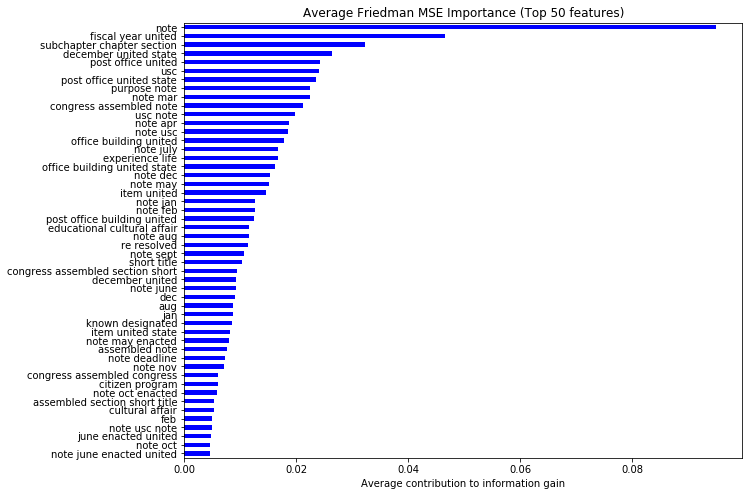

In [30]:
# Plot the feature importance
feat_scores = pd.Series(gb.feature_importances_,
                           index=features)

feat_scores = feat_scores.sort_values()[::-1][:50][::-1]
ax = feat_scores.plot(kind='barh', 
                      figsize=(10,8),
                      color='b')
ax.set_title('Average Friedman MSE Importance (Top 50 features)')
ax.set_xlabel('Average contribution to information gain')

In [61]:
data, in_progress = get_bill_data()

------------------
------------------
Data includes bills, joints resolutions, and laws with text from the 110th Congress (2007) to present
Make changes in my_tools.get_bill_data to modify the data set.
------------------


In [62]:
in_progress.shape

(26, 25)

In [63]:
# Get input of bill still in progress
input_corpus = process_corpus(in_progress, 'bill_text')

input_vec = tfvect.transform(input_corpus)
input_y_pred = gb.predict(input_vec)
input_y_pred_proba = gb.predict_proba(input_vec)


print(input_y_pred_proba)

------------------
Step 1 of 4: Creating corpus...
------------------
Step 2 of 4: Tokenizing...
------------------
Step 3 of 4: Stripping out stop words, punctuation, and numbers...
------------------
Step 4 of 4: Lemmatizing...
------------------
NLP preprocessing complete ...
[[0.99790061 0.00209939]
 [0.99790061 0.00209939]
 [0.99790061 0.00209939]
 [0.99889146 0.00110854]
 [0.99790061 0.00209939]
 [0.99790061 0.00209939]
 [0.99790061 0.00209939]
 [0.99790061 0.00209939]
 [0.99790061 0.00209939]
 [0.99790061 0.00209939]
 [0.99790061 0.00209939]
 [0.99790061 0.00209939]
 [0.99790061 0.00209939]
 [0.99790061 0.00209939]
 [0.99790061 0.00209939]
 [0.99790061 0.00209939]
 [0.99790061 0.00209939]
 [0.99790061 0.00209939]
 [0.99790061 0.00209939]
 [0.99790061 0.00209939]
 [0.99790061 0.00209939]
 [0.99790061 0.00209939]
 [0.99790061 0.00209939]
 [0.99790061 0.00209939]
 [0.99790061 0.00209939]
 [0.99790061 0.00209939]]
